In [258]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yfin
yfin.pdr_override()

In [216]:
def fetch_data(symbols, start_str, end_str):
    result = []
    # set date string format
    date_format = "%Y-%m-%d"
    # get start time and end time
    start_date = datetime.strptime(start_str, date_format)
    end_date = datetime.strptime(end_str, date_format)
    for symbol in symbols:
        print(f'Now fetching {symbol} data from Yahoo...')
        # get data from Yahoo finance
        data = pdr.get_data_yahoo(symbol, start = start_date, end = end_date)
        print(f'{symbol} data fetched successfully.')
        # add data to result
        result.append(data)
    return result

In [217]:
symbols = ['AMZN']
start = "2000-01-01"
end = "2023-12-01"

result = fetch_data(symbols, start, end)

Now fetching AMZN data from Yahoo...
[*********************100%%**********************]  1 of 1 completed
AMZN data fetched successfully.


In [218]:
AMZN = result[0]
AMZN.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [219]:
X_AMZN = AMZN.values

In [220]:
from sklearn.preprocessing import MinMaxScaler

In [221]:
def scale_df(df):
    scalers = []
    new_df = df.copy()
    for feature in new_df.columns:
        scaler = MinMaxScaler()
        new_df[feature] = scaler.fit_transform(new_df[feature].values.reshape(-1,1))
        scalers.append(scaler)
    return new_df, scalers

In [222]:
AMZN['Close'].values.reshape(-1,1).shape

(6017, 1)

In [223]:
AMZN_SCALED,  scalers = scale_df(AMZN) # scalers[4] will be used later to rescale the predict price from the model
AMZN_SCALED.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,0.020222,0.022156,0.019922,0.022388,0.022388,0.147285
2000-01-04,0.021258,0.022671,0.020654,0.020392,0.020392,0.160526
2000-01-05,0.017279,0.018324,0.016929,0.017120,0.017120,0.363237
2000-01-06,0.017496,0.017677,0.015845,0.015996,0.015996,0.172751
2000-01-07,0.016343,0.017096,0.016438,0.017070,0.017070,0.093033


In [224]:
# predict target is "Adj Close" price
Y_RAW = AMZN[["Adj Close"]].values
Y_SCALED = AMZN_SCALED[["Adj Close"]].values
X_ONE_FEATURE = AMZN_SCALED[["Adj Close"]].values.reshape(-1,1)
# Combine Open, High, Low, Close, Volumn in to a feature with 5 dimensions
X = AMZN_SCALED[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values
X_ALL_FEATURES = X.reshape(-1,5)


In [225]:
# use look_back days price to do the forecast
look_back = 20
# forecast next 10 days price
next_days = 2

In [226]:
def get_shifted_y(arr, look_back = look_back, next_days = next_days):
    # for example, if we want to use today's price to predict next one day price
    # then look_back = 1, next_days = 1, so the first row of shifted data (in ascending date)
    # should be the second row of original data, means the shifted data shoulbe be arr[1:]
  return arr[look_back + next_days - 1:]

def get_shifted_x(arr, look_back = look_back, next_days = next_days):
   # the total length of new x should be original length - (look_back + next_days - 1)
   # for example, if we want to use today's data to predict next one day's price,
   # the length of new x should be oritinal length - (1 + 1 -1) 
   new_len = len(arr) - (look_back + next_days - 1)
   # we need to get a list of history price with length = look_back to forcast the next_days price
   # the first column of the history price should be start at first row of original data and
   # end at new_len - 1
   all_columns = []
   for i in range(look_back):
       current_column = arr[i:i+new_len]
       all_columns.append(current_column)
   new_x = np.stack(all_columns, axis = 1)
   return new_x

In [227]:
X_ONE = get_shifted_x(X_ONE_FEATURE)
X_ALL = get_shifted_x(X_ALL_FEATURES)
Y = get_shifted_y(Y_SCALED)
Y_SR = get_shifted_y(Y_RAW) # shifted Y_RAW
# size of shifted data
X_ONE.shape, X_ALL.shape, Y.shape, Y_SR.shape

((5996, 20, 1), (5996, 20, 5), (5996, 1), (5996, 1))

In [244]:
def get_train_val(x, y, y_raw):
  # get data size
  data_size = len(x)
  # split the data into training and validation
  split = data_size - 200 # only use recent 200 price for validation
  Xtrain = tf.convert_to_tensor(x[:split], dtype=tf.float32)
  ytrain = tf.convert_to_tensor(y[:split], dtype=tf.float32)
  Xval = tf.convert_to_tensor(x[split:], dtype=tf.float32)
  yval = tf.convert_to_tensor(y[split:], dtype=tf.float32)
  
  return Xtrain, ytrain, Xval, yval, y_raw[split:]

In [245]:
# train model using X_ONE
Xtrain, ytrain, Xval, yval, Y_SR_VAL = get_train_val(X_ONE, Y, Y_SR)
Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Y_SR_VAL.shape

(TensorShape([5796, 20, 1]),
 TensorShape([5796, 1]),
 TensorShape([200, 20, 1]),
 TensorShape([200, 1]),
 (200, 1))

In [246]:
from keras.models import Sequential
from keras.layers import GRU, SimpleRNN, LSTM, Activation, Dropout, Dense, Reshape, Conv1D, Conv2D, Flatten, MaxPooling2D
from sklearn.metrics import mean_squared_error

In [247]:
model_one = Sequential()
# model_one.add(GRU(128, input_shape=(20, 1)))
model_one.add(GRU(128, input_shape=(20, 1), return_sequences=False))
model_one.add(Dropout(0.25))
# model_one.add(GRU(128, return_sequences=False))
# model_one.add(Dropout(0.25))
model_one.add(Dense(128, activation='relu'))
model_one.add(Dropout(0.25))
model_one.add(Dense(1, activation='linear'))
model_one.compile(loss='mean_squared_error', optimizer='adam')
model_one.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 128)               50304     
                                                                 
 dropout_34 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dropout_35 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66945 (261.50 KB)
Trainable params: 66945 (261.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [248]:
# define a helper function
def train_model(model, X, y, epochs = 30, batch_size = 32, verbose = 2):
  model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0)
train_model(model_one, Xtrain, ytrain)

Epoch 1/30
182/182 - 6s - loss: 0.0048 - 6s/epoch - 34ms/step
Epoch 2/30
182/182 - 2s - loss: 0.0014 - 2s/epoch - 13ms/step
Epoch 3/30
182/182 - 2s - loss: 0.0012 - 2s/epoch - 13ms/step
Epoch 4/30
182/182 - 3s - loss: 0.0012 - 3s/epoch - 14ms/step
Epoch 5/30
182/182 - 2s - loss: 0.0011 - 2s/epoch - 14ms/step
Epoch 6/30
182/182 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step
Epoch 7/30
182/182 - 2s - loss: 0.0011 - 2s/epoch - 13ms/step
Epoch 8/30
182/182 - 2s - loss: 0.0010 - 2s/epoch - 13ms/step
Epoch 9/30
182/182 - 2s - loss: 9.3465e-04 - 2s/epoch - 13ms/step
Epoch 10/30
182/182 - 2s - loss: 9.1704e-04 - 2s/epoch - 13ms/step
Epoch 11/30
182/182 - 2s - loss: 9.5857e-04 - 2s/epoch - 13ms/step
Epoch 12/30
182/182 - 2s - loss: 9.3885e-04 - 2s/epoch - 13ms/step
Epoch 13/30
182/182 - 3s - loss: 8.6767e-04 - 3s/epoch - 14ms/step
Epoch 14/30
182/182 - 2s - loss: 8.4838e-04 - 2s/epoch - 13ms/step
Epoch 15/30
182/182 - 2s - loss: 9.5033e-04 - 2s/epoch - 13ms/step
Epoch 16/30
182/182 - 2s - loss: 8.7

In [256]:
def predict(model, X, scaler = scalers[4]):
  if scaler == None:
    return model.predict(X)
  return scaler.inverse_transform(model.predict(X))

# create a evaluation function
def get_model_perf(model, X, y = Y_SR_VAL, scaler = scalers[4]):
  pred = predict(model, X, scaler=scaler)
  rmse = np.sqrt(np.mean((pred - y)**2))
  print('RMSE: %.3f\n' % (rmse))
  relative_err = np.mean(np.abs( (pred-y)/y ) )
  print(f'Relative Error: {relative_err*100:.2f}%')
  return pred, rmse, relative_err

In [265]:
# show RMSE and relative error value on validation data
pred_one, RMSE, REL_ERR = get_model_perf(model_one, Xval)

7/7 [==============================] - 0s 7ms/step
RMSE: 3.368

Relative Error: 2.13%


In [263]:
def plot_pred(pred, real, start_pos=0, end_pos=-1):
    if len(pred) > len(real):
      print("Error: length of pred is larger than the length of real")
      return
    # if end_pos is -1, set to end_pos to the end of the data
    end_pos = end_pos if end_pos != -1 else len(real)
    # set data in real to plot
    real_to_plot = real[start_pos : end_pos]
    # set prediction data to plot
    pred_to_plot = pred[start_pos : end_pos]
    plt.plot(real_to_plot)
    plt.plot(pred_to_plot, "--")

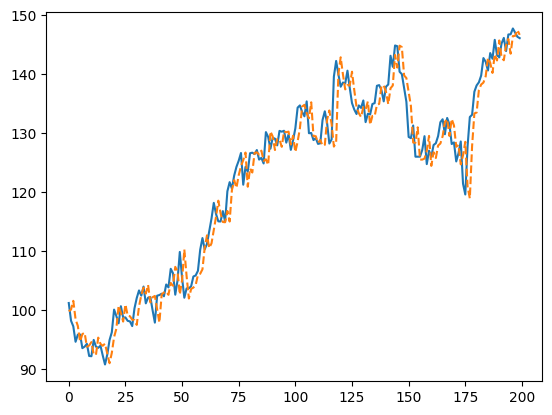

In [266]:
plot_pred(pred_one, Y_SR_VAL)

In [252]:
model_all = Sequential()
# model_all.add(GRU(128, input_shape=(20, 1)))
model_all.add(GRU(128, input_shape=(20, 5), return_sequences=False))
model_all.add(Dropout(0.25))
# model_all.add(GRU(128, return_sequences=False))
# model_all.add(Dropout(0.25))
model_all.add(Dense(128, activation='relu'))
model_all.add(Dropout(0.25))
model_all.add(Dense(1, activation='linear'))
model_all.compile(loss='mean_squared_error', optimizer='adam')
model_all.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_15 (GRU)                (None, 128)               51840     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dropout_37 (Dropout)        (None, 128)               0         
                                                                 
 dense_32 (Dense)            (None, 1)                 129       
                                                                 
Total params: 68481 (267.50 KB)
Trainable params: 68481 (267.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [253]:
# train model using X_ONE
Xtrain_all, ytrain_all, Xval_all, yval_all, _ = get_train_val(X_ALL, Y, Y_SR)
# size of train, val data
Xtrain_all.shape, ytrain_all.shape, Xval_all.shape, yval_all.shape, Y_SR_VAL.shape

(TensorShape([5796, 20, 5]),
 TensorShape([5796, 1]),
 TensorShape([200, 20, 5]),
 TensorShape([200, 1]),
 (200, 1))

In [254]:
train_model(model_all, Xtrain_all, ytrain_all)

Epoch 1/30
182/182 - 6s - loss: 0.0028 - 6s/epoch - 31ms/step
Epoch 2/30
182/182 - 3s - loss: 0.0017 - 3s/epoch - 14ms/step
Epoch 3/30
182/182 - 3s - loss: 0.0012 - 3s/epoch - 14ms/step
Epoch 4/30
182/182 - 3s - loss: 0.0012 - 3s/epoch - 14ms/step
Epoch 5/30
182/182 - 3s - loss: 0.0012 - 3s/epoch - 14ms/step
Epoch 6/30
182/182 - 3s - loss: 0.0010 - 3s/epoch - 14ms/step
Epoch 7/30
182/182 - 3s - loss: 9.8340e-04 - 3s/epoch - 15ms/step
Epoch 8/30
182/182 - 3s - loss: 9.7936e-04 - 3s/epoch - 16ms/step
Epoch 9/30
182/182 - 3s - loss: 9.8100e-04 - 3s/epoch - 16ms/step
Epoch 10/30
182/182 - 3s - loss: 9.4174e-04 - 3s/epoch - 14ms/step
Epoch 11/30
182/182 - 3s - loss: 9.5690e-04 - 3s/epoch - 18ms/step
Epoch 12/30
182/182 - 4s - loss: 9.7614e-04 - 4s/epoch - 20ms/step
Epoch 13/30
182/182 - 3s - loss: 8.6099e-04 - 3s/epoch - 19ms/step
Epoch 14/30
182/182 - 3s - loss: 9.0027e-04 - 3s/epoch - 19ms/step
Epoch 15/30
182/182 - 3s - loss: 9.3840e-04 - 3s/epoch - 16ms/step
Epoch 16/30
182/182 - 2s - l

In [268]:
# show RMSE and relative error value on validation data
pred_all, RMSE, REL_ERR = get_model_perf(model_all, Xval_all)

7/7 [==============================] - 0s 7ms/step
RMSE: 3.889

Relative Error: 2.52%


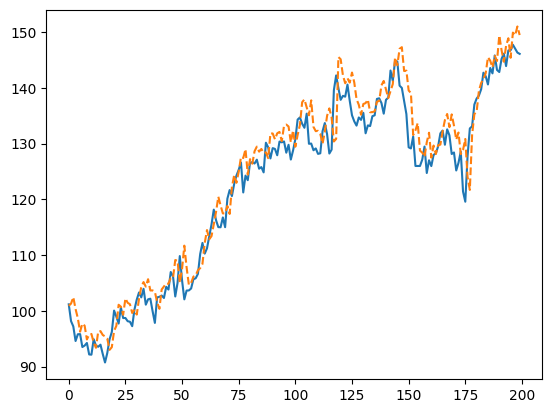

In [271]:
plot_pred(pred_all, Y_SR_VAL)

#### Observation
Compared with the previous prediction using only history price, the prediction using all history features("Open", "Close", "High", "Adj Close", "Volume") performs worse.